# Age prediction


In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import umap
from itertools import cycle
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import nested_crossvalidation
from utilities import nested_ROC_plot
from utilities import montecarlo_crossvalidation
from utilities import model_optimization
from utilities import variable_importance_df
from utilities import gridsearch_bias

/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-usin

In [4]:
colors = sn.color_palette("Set2") 

In [5]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldataset.dat", sep='\t')
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [6]:
tsetse_data_copy = tsetse_data.copy()

In [7]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF = tsetse_data_copy[dList]

In [8]:
tsetse_males_thorax = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'm') & (descriptorsDF['Tissue'] == 'Thorax')]

tsetse_males_head = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'm') & (descriptorsDF['Tissue'] == 'Head')]

In [9]:
tsetse_males_thorax.groupby("Age")["ID"].count()

Age
5w    93
7w    92
Name: ID, dtype: int64

In [10]:
tsetse_males_head.groupby("Age")["ID"].count()

Age
5w    94
7w    93
Name: ID, dtype: int64

In [11]:
tsetse_males_thorax_copy = tsetse_males_thorax.copy()
tsetse_males_head_copy = tsetse_males_head.copy()

In [12]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF_thorax = tsetse_males_thorax[dList]
tsetse_males_thorax_copy.drop(dList, axis=1,inplace=True)


descriptorsDF_head = tsetse_males_head_copy[dList]
tsetse_males_head_copy.drop(dList, axis=1,inplace=True)

In [13]:
waveNumslist = tsetse_males_thorax_copy.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [14]:
y_labels_head = descriptorsDF_head['Age']
y_labels_thorax = descriptorsDF_thorax['Age']

## Clustering

In [21]:
# males head
reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_males_head_copy)
embedding_head = reducer.fit_transform(features_scaled)

In [22]:
# Females thorax
reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_males_thorax_copy)
embedding_thorax= reducer.fit_transform(features_scaled)

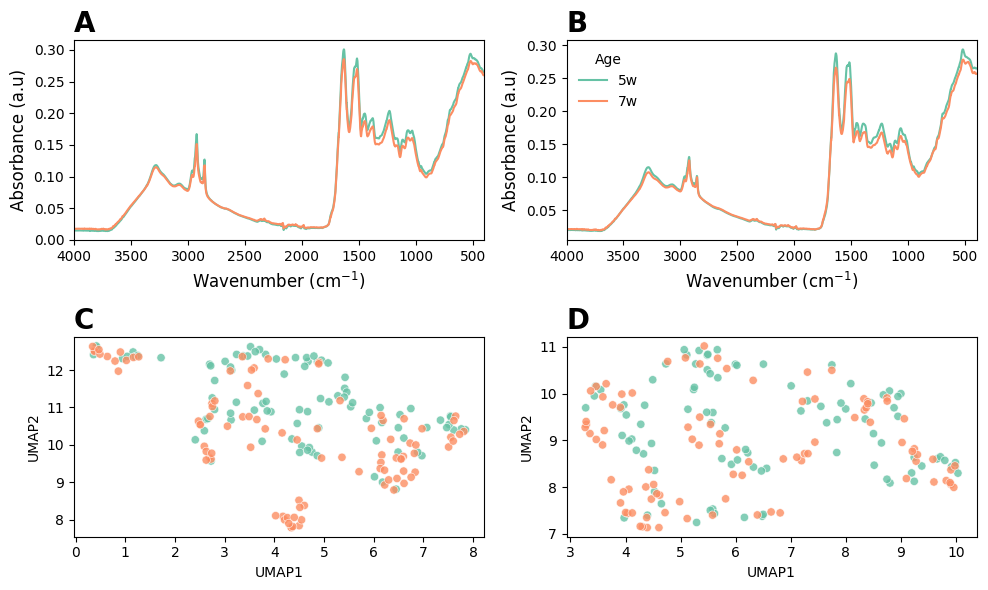

In [23]:
sn.set_palette("Set2")

fig, ((ax, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,6))

# head
sn.scatterplot(x=embedding_head[:,0], y=embedding_head[:,1], alpha=0.8, hue=descriptorsDF_head['Age'],ax=ax3, legend=False)
ax3.set_xlabel("UMAP1")
ax3.set_ylabel("UMAP2")

# thorax
sn.scatterplot(x=embedding_thorax[:,0], y=embedding_thorax[:,1], alpha=0.8, hue=descriptorsDF_thorax['Age'],legend=False,ax=ax4)
ax4.set_xlabel("UMAP1")
ax4.set_ylabel("UMAP2")
#ax3.legend( bbox_to_anchor=(0.5, 0.05, 0.3, 0.1),ncols=3,frameon=False)



# head
for i, c in zip(np.unique(y_labels_head), colors):
    sn.lineplot(x=wavenumbers, y=np.mean(tsetse_males_head_copy[y_labels_head == i], axis=0), label=i, color=c, ax=ax)
ax.get_legend().remove()
ax.set_xlim(4000,401)
ax.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)
ax.set_ylabel("Absorbance (a.u)",fontsize=12)

# thorax
for i, c in zip(np.unique(y_labels_thorax), colors):
    sn.lineplot(x=wavenumbers, y=np.mean(tsetse_males_thorax_copy[y_labels_thorax == i], axis=0), label=i, color=c,ax=ax2)
ax2.set_xlim(4000,401)
ax2.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)
ax2.set_ylabel("Absorbance (a.u)",fontsize=12)
ax2.legend(title="Age",frameon=False)


labeles = ["A", "B", "C", "D", "E", "F"]
axes = fig.get_axes()
for a, l in zip(axes, labeles):
    a.set_title(l, loc='left', fontsize=20, fontweight='bold')



plt.tight_layout()
plt.savefig("../results/plots/UMAP_Spectra_age_males.png", dpi=300)

## Age prediction males

In [15]:
# Thorax

X_thorax_part1 = tsetse_males_thorax.loc[:,"4000":"402"]
X_thorax_part2 = tsetse_males_thorax.loc[:,"1800":"600"]
X_thorax_part3 = tsetse_males_thorax.loc[:,"3500":"2750"]
X_thorax_part4 = tsetse_males_thorax.loc[:,"2750":"1800"]

X_thorax_desbiased = pd.concat([X_thorax_part3,X_thorax_part2],axis=1)

y_thorax = tsetse_males_thorax.loc[:,"Age"]



In [16]:
# head

X_head_part1 = tsetse_males_head.loc[:,"4000":"402"]
X_head_part2 = tsetse_males_head.loc[:,"1800":"600"]
X_head_part3 = tsetse_males_head.loc[:,"3500":"2750"]
X_head_part4 = tsetse_males_head.loc[:,"2750":"1800"]

X_head_desbiased = pd.concat([X_head_part3,X_head_part2],axis=1)


y_head = tsetse_males_head.loc[:,"Age"]

In [17]:
waveNumslist_reduced = X_thorax_desbiased.columns.values.tolist()
wavenumbers_reduced = [int(x) for x in waveNumslist_reduced]

In [301]:
# Probabilities LR

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline

clf = LogisticRegression(max_iter=1000)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

pipe = Pipeline([('scaler', StandardScaler()),('clf', clf)])

pipe.fit(X_head_part4, y_head)
ypred = pipe.predict(X_head_part4)

pred_proba = pipe.predict_proba(X_head_part4)

In [302]:
x = pred_proba[:,1]


<Axes: ylabel='Count'>

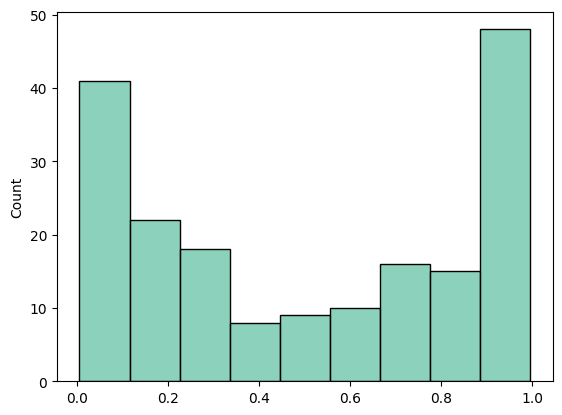

In [303]:
sn.histplot(pred_proba[:,0], label="negatives")

In [299]:
# Probabilities LR

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline

clf = LogisticRegression(max_iter=1000)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

pipe = Pipeline([('scaler', StandardScaler()),('clf', clf)])

pipe.fit(X_head_part2, y_head)
ypred = pipe.predict(X_head_part2)

pred_proba = pipe.predict_proba(X_head_part2)
xx = pred_proba[:,1]

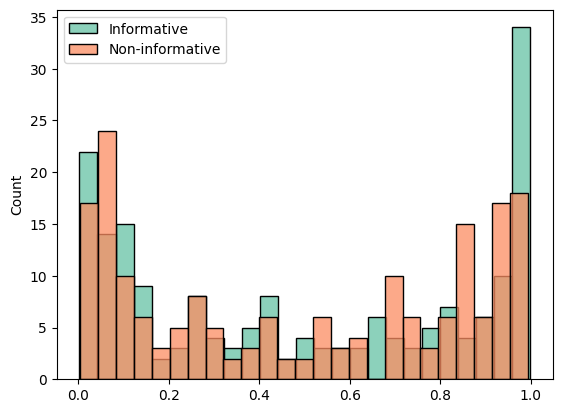

In [343]:
sn.histplot(xx, bins=25, label='Informative')
sn.histplot(x, bins=25,label='Non-informative')
plt.legend()

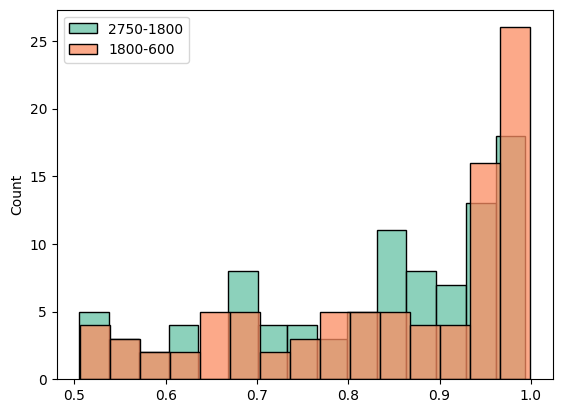

In [313]:
sn.histplot(x[x >= 0.5], bins=15, label='2750-1800')
sn.histplot(xx[xx >= 0.5], bins=15, label='1800-600')
plt.legend()


In [331]:
# Calibration test

from sklearn.calibration import calibration_curve

clf = LogisticRegression(max_iter=1000)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

pipe = Pipeline([('scaler', StandardScaler()),('clf', clf)])

pipe.fit(X_head_part2, y_head)
ypred = pipe.predict(X_head_part2)

pred_proba_a = pipe.decision_function(X_head_part2)

fop, mpv = calibration_curve(y_head, pred_proba_a, pos_label='7w', n_bins=10, normalize=True)

/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


In [345]:
clf = LogisticRegression(max_iter=1000)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

pipe = Pipeline([('scaler', StandardScaler()),('clf', clf)])

pipe.fit(X_head_part4, y_head)
ypred = pipe.predict(X_head_part4)

pred_proba_a = pipe.decision_function(X_head_part4)

fop_1, mpv_1 = calibration_curve(y_head, pred_proba_a, pos_label='7w', n_bins=10, normalize=True)

/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


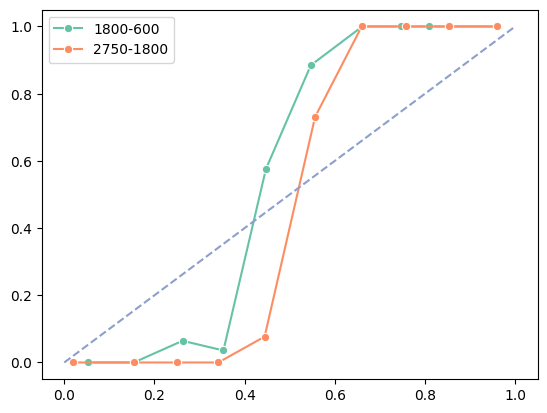

In [347]:
sn.lineplot(x=mpv, y=fop, marker='o', label='1800-600')
sn.lineplot(x=mpv_1, y=fop_1, marker='o', label='2750-1800')
sn.lineplot(x=[0, 1], y=[0, 1], linestyle='--')
plt.legend()

In [18]:
# permutation test

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


In [270]:
models = [] # creating empty lists
models.append(("Logistic Regression", LogisticRegression(max_iter = 1000)))
models.append(("Support vector machine", SVC(kernel='linear')))
models.append(("Support vector machine_rbf", SVC(kernel='rbf')))
models.append(("RF", RandomForestClassifier()))

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

parts = []
parts.append(("4000-402", X_head_part1))
parts.append(("1800-600", X_head_part2))
parts.append(("3500-2750", X_head_part3))
parts.append(("2750-1800", X_head_part4))
parts.append(("1800-600,3500-2750", X_head_desbiased))


totaldicts = {}
dicts = {}
for a, i in parts:
    for name, model in tqdm(models):
        pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
        score_age, perm_scores_age, pvalue_age = permutation_test_score(
        pipe, i, y_head, scoring="accuracy", cv=cv, n_permutations=100)
    #print(f'Permutation score is for model {name} is {np.mean(perm_scores_age):.2f}')
        dicts[model] = [np.mean(perm_scores_age),pvalue_age]
        #dicts[f'pvalue{model}'] = pvalue_age
    totaldicts[a] = dicts

100%|██████████| 4/4 [52:11<00:00, 782.94s/it] 


In [271]:
pd.DataFrame(totaldicts)

,4000-402,1800-600,3500-2750,2750-1800,"1800-600,3500-2750"
LogisticRegression(max_iter=1000),"[0.49794736842105264, 0.009900990099009901]","[0.49794736842105264, 0.009900990099009901]","[0.49794736842105264, 0.009900990099009901]","[0.49794736842105264, 0.009900990099009901]","[0.49794736842105264, 0.009900990099009901]"
SVC(kernel='linear'),"[0.5006842105263157, 0.009900990099009901]","[0.5006842105263157, 0.009900990099009901]","[0.5006842105263157, 0.009900990099009901]","[0.5006842105263157, 0.009900990099009901]","[0.5006842105263157, 0.009900990099009901]"
SVC(),"[0.5078421052631579, 0.009900990099009901]","[0.5078421052631579, 0.009900990099009901]","[0.5078421052631579, 0.009900990099009901]","[0.5078421052631579, 0.009900990099009901]","[0.5078421052631579, 0.009900990099009901]"
RandomForestClassifier(),"[0.49915789473684213, 0.009900990099009901]","[0.49915789473684213, 0.009900990099009901]","[0.49915789473684213, 0.009900990099009901]","[0.49915789473684213, 0.009900990099009901]","[0.49915789473684213, 0.009900990099009901]"


In [272]:
permutation_results = pd.DataFrame(totaldicts)
permutation_results.to_excel("../results/tables/permutation_results_age_males.xlsx")

## Assesment of predict

In [47]:
data_segments = []
data_segments.append(("1800-600",X_thorax_part1))
data_segments.append(("3500-2750",X_thorax_part2))
data_segments.append(("2750-1800",X_thorax_part3))
data_segments.append(("1800-600 and 3500-2750",X_thorax_desbiased))

#data_segments = [X_thorax_part1, X_thorax_part2, X_thorax_part3,X_thorax_desbiased]


In [61]:
models = [] # creating empty lists
models.append(("Logistic Regression", LogisticRegression(max_iter = 1000)))
models.append(("Support vector machine", SVC()))
models.append(("RF", RandomForestClassifier()))

In [275]:
sss = StratifiedShuffleSplit(n_splits=10, random_state=7, test_size=0.3)
for name, model in models:
    print(f"\n{name} is being test it now\n...")
    for names, segment in data_segments:
        pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
        cv_results = cross_val_score(pipe, X=segment,y=y_thorax, scoring='accuracy',cv=sss)
        print(f"Segment {names} accuracy is {np.mean(cv_results):.2f} ± {np.std(cv_results):.2f}")



Logistic Regression is being test it now
...
Segment 1800-600 accuracy is 0.84 ± 0.05
Segment 3500-2750 accuracy is 0.78 ± 0.05
Segment 2750-1800 accuracy is 0.87 ± 0.05
Segment 1800-600 and 3500-2750 accuracy is 0.84 ± 0.04

Support vector machine is being test it now
...
Segment 1800-600 accuracy is 0.86 ± 0.05
Segment 3500-2750 accuracy is 0.81 ± 0.04
Segment 2750-1800 accuracy is 0.92 ± 0.04
Segment 1800-600 and 3500-2750 accuracy is 0.89 ± 0.04

Support vector machine_rbf is being test it now
...
Segment 1800-600 accuracy is 0.79 ± 0.05
Segment 3500-2750 accuracy is 0.59 ± 0.05
Segment 2750-1800 accuracy is 0.53 ± 0.07
Segment 1800-600 and 3500-2750 accuracy is 0.76 ± 0.07

RF is being test it now
...
Segment 1800-600 accuracy is 0.74 ± 0.06
Segment 3500-2750 accuracy is 0.67 ± 0.06
Segment 2750-1800 accuracy is 0.59 ± 0.07
Segment 1800-600 and 3500-2750 accuracy is 0.75 ± 0.04


In [141]:
def gridsearch_bias(X_thorax_part1, y_thorax):
    clf1 = LogisticRegression(max_iter=1000, random_state=123)
    clf2 = SVC(random_state=123)
    clf3 = RandomForestClassifier(random_state=123)

    param1 = {}
    param1['clf__kernel'] = ['rbf','linear']
    param1['clf'] = [clf2]

    param2 ={}
    param2['clf'] = [clf1]

    param3 = {}
    param3['clf'] = [clf3]

    pipe = Pipeline([('scaler', StandardScaler()), ('clf', clf1)])
    params = [param1, param2, param3]
    cv = StratifiedShuffleSplit(n_splits=10, random_state=7, test_size=0.2)

    grid = GridSearchCV(pipe, params, cv=cv, scoring='accuracy')

    results_part1 = grid.fit(X_thorax_part1,y_thorax)

    dx = pd.DataFrame.from_dict(results_part1.cv_results_)
    mean_accuracies = dx[["param_clf","param_clf__kernel","mean_test_score"]]
    mean_accuracies_copy = mean_accuracies.copy()

    mean_accuracies_copy['param_clf'] =  mean_accuracies_copy['param_clf'].astype(str)
    mean_accuracies_copy['param_clf'] =  mean_accuracies_copy['param_clf'].str.replace('LogisticRegression(max_iter=1000, random_state=123)',repl='LR', regex=False)
    mean_accuracies_copy['param_clf'] =  mean_accuracies_copy['param_clf'].str.replace("SVC(kernel='linear', random_state=123)", 'SVM',regex=False)
    mean_accuracies_copy['param_clf'] =  mean_accuracies_copy['param_clf'].str.replace('RandomForestClassifier(random_state=123)', 'RF', regex=False)

    return mean_accuracies_copy

In [172]:
# thorax
bias_test_part1 = gridsearch_bias(X_thorax_part1,y_thorax)
bias_test_part2 = gridsearch_bias(X_thorax_part2,y_thorax)
bias_test_part3 = gridsearch_bias(X_thorax_part3,y_thorax)
bias_test_part4 = gridsearch_bias(X_thorax_part4,y_thorax)
bias_test_part5 = gridsearch_bias(X_thorax_desbiased,y_thorax)

In [174]:
result = pd.concat([bias_test_part1, bias_test_part2['mean_test_score'],bias_test_part3['mean_test_score'],bias_test_part4['mean_test_score'],bias_test_part5['mean_test_score']], axis=1)
result

result.to_excel("../results/tables/results_biased_test.xlsx")

In [181]:
# head

bias_test_head_part1 = gridsearch_bias(X_head_part1, y_head)
bias_test_head_part2 = gridsearch_bias(X_head_part2, y_head)
bias_test_head_part3 = gridsearch_bias(X_head_part3, y_head)
bias_test_head_part4 = gridsearch_bias(X_head_part4, y_head)
bias_test_head_part5 = gridsearch_bias(X_head_desbiased, y_head)

In [191]:
bias_test_head_part1

,param_clf,param_clf__kernel,mean_test_score
0,SVC(random_state=123),rbf,0.705263
1,SVC(random_state=123),linear,0.889474
2,LR,NaN,0.900000
3,RF,NaN,0.686842


In [188]:
result = pd.concat([bias_test_head_part1, 
    bias_test_head_part2['mean_test_score'],
    bias_test_head_part3['mean_test_score'],
    bias_test_head_part4['mean_test_score'],
    bias_test_head_part5['mean_test_score']], axis=1)

result.to_excel("../results/tables/results_biased_head_test.xlsx")

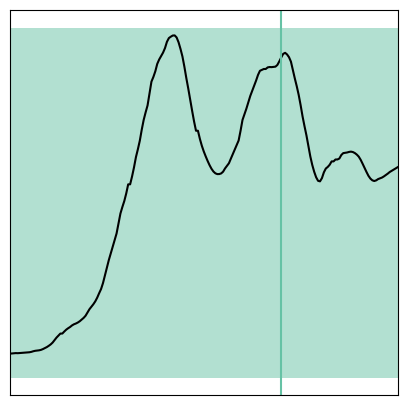

In [217]:
fig, ax = plt.subplots(figsize=(5,5))
sn.lineplot(x=wavenumbers, y=np.mean(tsetse_males_head_copy,axis=0),ax=ax,color='k')
ax.fill_betweenx(y=(0,0.3),x1=4000,x2=400,alpha=0.5)
#ax.fill_betweenx(y=(0,0.3),x1=3500,x2=2750,alpha=0.5)
ax.set_xlim(1800,1400)
ax.axvline(1520,0,1)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',
    labelbottom=False,
    labeltop=False,
    labelright=False,
    labelleft=False,
    bottom=False,
    top=False,
    left=False,
    right=False)


(0.0, 1.0)

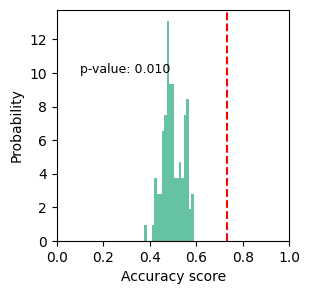

In [21]:
sn.set_palette('Set2')
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(perm_scores_age, bins=20, density=True)
ax.axvline(score_age, ls="--", color="r")
score_label = f"p-value: {pvalue_age:.3f}"
ax.text(0.1, 10, score_label, fontsize=9)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
ax.set_xlim(0,1)

#plt.savefig("../results/plots/permutationtest_age_males.png", dpi=300, bbox_inches='tight')

# Age prediction using the whole spectra

In [18]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax_part1, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head_part1, y_head, test_size=0.2, shuffle=True, random_state=123)

In [19]:
shape_data = {"train_head": X_hd_train.shape,
              "train_thorax": X_th_train.shape,
              "test_head": X_hd_test.shape,
              "tsetse_thorax":X_th_test.shape}

In [20]:
shape_data_df = pd.DataFrame(shape_data,index=['samples','features'])
shape_data_df

,train_head,train_thorax,test_head,tsetse_thorax
samples,149,148,38,37
features,1800,1800,1800,1800


In [18]:
shape_data_df.to_excel("../results/tables/train_test_shape_age_males.xlsx")

In [19]:
shape_data_classes = {"train_head": y_hd_train.value_counts(),
              "train_thorax": y_th_train.value_counts(),
              "test_head": y_hd_test.value_counts(),
              "tsetse_thorax":y_th_test.value_counts()}

shape_data_classes_df = pd.DataFrame(shape_data_classes)
shape_data_classes_df
shape_data_classes_df.to_excel("../results/tables/train_test_shape_age_classes_males.xlsx")

In [21]:
females_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
females_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [22]:
data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
data_plot_head = dataplotmelt(females_head_acc_baseline)

<Axes: xlabel='param_clf', ylabel='value'>

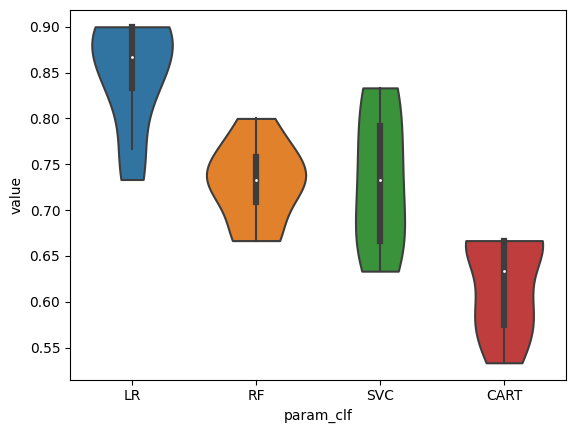

In [23]:
sn.violinplot(data=data_plot_head, x='param_clf',y='value', cut=0)

In [111]:
output = data_plot_head.groupby(["param_clf"], as_index=False).agg({'value':['mean', 'std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.620000  0.052587
1        LR  0.850000  0.059317
2        RF  0.730000  0.042889
3       SVC  0.733333  0.073703


In [112]:
output = data_plot_thorax.groupby(["param_clf"], as_index=False).agg({'value':['mean', 'std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.723333  0.056765
1        LR  0.883333  0.045134
2        RF  0.743333  0.081725
3       SVC  0.690000  0.070361


In [24]:
# model optimization

# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)


Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [25]:
# thorax

best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [26]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, best_model_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, best_mdoel_thorax)

In [27]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.8947368421052632
Accuracy on test set: 0.918918918918919


In [28]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head

,precision,recall,f1-score,support
5w,0.958333,0.884615,0.920000,26.000000
7w,0.785714,0.916667,0.846154,12.000000
accuracy,0.894737,0.894737,0.894737,0.894737
macro avg,0.872024,0.900641,0.883077,38.000000
weighted avg,0.903822,0.894737,0.896680,38.000000


In [125]:
report_head.to_excel("../results/tables/accuracy_age_males_head.xlsx")

In [29]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax

,precision,recall,f1-score,support
5w,0.952381,0.909091,0.930233,22.000000
7w,0.875000,0.933333,0.903226,15.000000
accuracy,0.918919,0.918919,0.918919,0.918919
macro avg,0.913690,0.921212,0.916729,37.000000
weighted avg,0.921010,0.918919,0.919284,37.000000


In [127]:
report_thorax.to_excel("../results/tables/accuracy_age_males_thorax.xlsx")

In [30]:
roc_head = roc_auc_score(y_hd_test, pipe_head.predict_proba(X_hd_test)[:,1])

In [232]:
auc_roc_results = pd.DataFrame({"ROC value": [roc_auc_score(y_hd_test, pipe_head.predict_proba(X_hd_test)[:,1]), roc_auc_score(y_th_test, pipe_thorax.predict_proba(X_th_test)[:,1])]},index=['head','thorax'])

print(auc_roc_results)

auc_roc_results.to_excel("../results/tables/roc_values_age_males.xlsx")


        ROC value
head     0.987179
thorax   0.948485


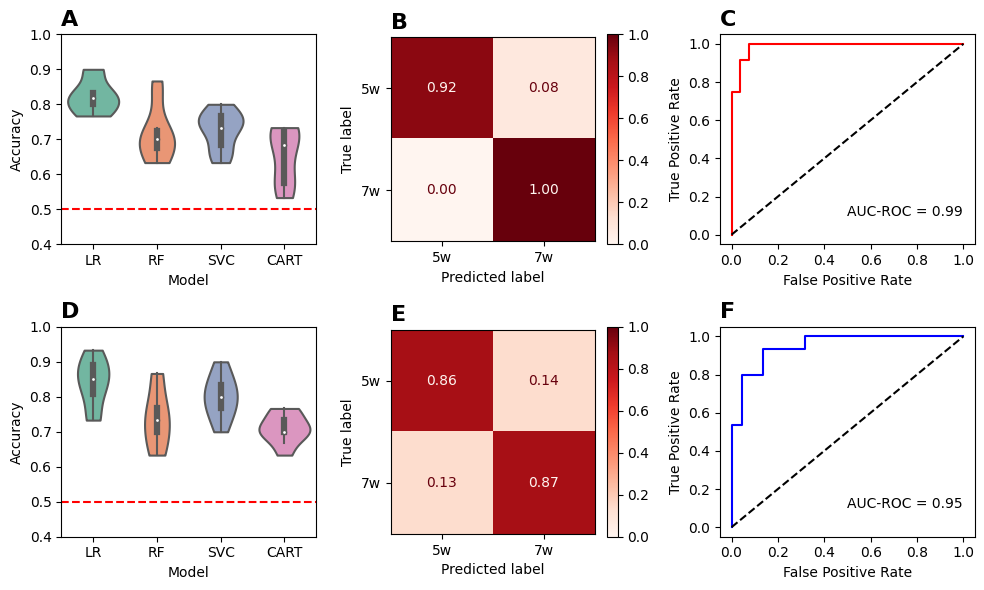

In [233]:
fig, ((ax,ax2, ax5),(ax3,ax4, ax6)) = plt.subplots(2,3,figsize=(10,6))
sn.violinplot(data=data_plot_head, x='param_clf',y='value',ax=ax, cut=0)
sn.violinplot(data=data_plot_thorax, x='param_clf', y='value', cut=0,ax=ax3)
ax.set_xlabel("Model")
ax.set_ylabel('Accuracy')
ax3.set_ylabel("Accuracy")
ax.set_ylim(0.4,1)
ax3.set_ylim(0.4,1)
ax.axhline(0.5, color='r',ls="--")
ax3.axhline(0.5, color='r',ls="--")

ax3.set_xlabel("Model")


disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})



disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})


RocCurveDisplay.from_estimator(pipe_head, X=X_hd_test, y=y_hd_test, ax=ax5, color='r')
ax5.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
ax5.get_legend().remove()
ax5.set_ylabel("True Positive Rate")
ax5.set_xlabel("False Positive Rate")

RocCurveDisplay.from_estimator(pipe_thorax, X=X_th_test, y=y_th_test, ax=ax6, color='b')
ax6.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
ax6.get_legend().remove()
ax6.set_ylabel("True Positive Rate")
ax6.set_xlabel("False Positive Rate")

ax5.text(0.5,0.1,s=(f"AUC-ROC = {roc_auc_score(y_hd_test, pipe_head.predict_proba(X_hd_test)[:,1]):.2f}"))

ax6.text(0.5,0.1,s=(f"AUC-ROC = {roc_auc_score(y_th_test, pipe_thorax.predict_proba(X_th_test)[:,1]):.2f}"))



sizeletters = 16
ax.set_title("A", loc='left', weight='bold',size=sizeletters)
ax2.set_title("B", loc='left', weight='bold', size=sizeletters)
ax3.set_title("D", loc='left', weight='bold', size=sizeletters)
ax4.set_title("E", loc='left', weight='bold', size=sizeletters)
ax5.set_title("C", loc='left', weight='bold', size=sizeletters)
ax6.set_title("F", loc='left', weight='bold', size=sizeletters)

plt.tight_layout()

#plt.savefig("../results/plots/age_prediction_males.png", dpi=300)

In [234]:
# monte carlo cross validation
# head
accuracy_head_mc, sensitivity_head_mc, specificity_head_mc = montecarlo_crossvalidation(X_head, y_head, best_model_head)



shuffle split: 100%|██████████| 100/100 [00:02<00:00, 38.19it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.82 ± 0.06


In [236]:
accuracy_thorax_mc, sensitivity_thorax_mc, specificity_thorax_mc = montecarlo_crossvalidation(X_thorax, y_thorax, best_mdoel_thorax)

shuffle split: 100%|██████████| 100/100 [00:06<00:00, 15.46it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.91 ± 0.05


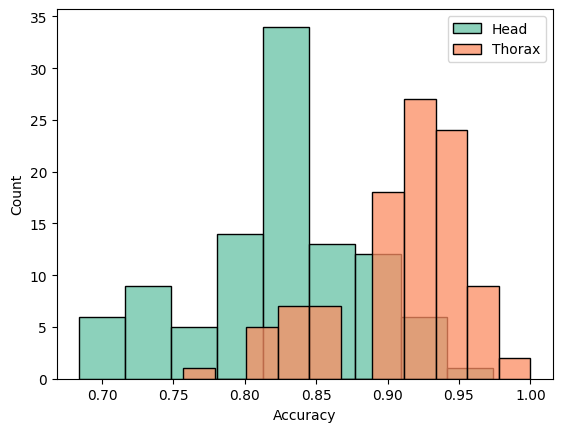

In [237]:
fig, ax = plt.subplots()
sn.histplot(accuracy_head_mc, label='Head', ax=ax)
sn.histplot(accuracy_thorax_mc, label='Thorax',ax=ax)
ax.set_xlabel("Accuracy")
plt.legend()


In [105]:
monte_carlo = pd.DataFrame({"Accuracy": [np.mean(accuracy_head_mc),
                                         np.mean(accuracy_thorax_mc)], 
                            "std":[np.std(accuracy_head_mc),
                                   np.std(accuracy_thorax_mc)], 
                            "Sensitivity":[np.mean(sensitivity_head_mc),
                                           np.mean(sensitivity_thorax_mc)],
                            "std_s": [np.std(sensitivity_head_mc),
                                           np.std(sensitivity_thorax_mc)],
                            "Specificity": [np.mean(specificity_head_mc),
                                          np.mean(specificity_thorax_mc)],
                            "std_sp": [np.std(specificity_head_mc),
                                          np.std(specificity_thorax_mc)]}, index=['head','thorax'])

In [106]:
monte_carlo.to_excel("../results/tables/age_prediction_males_mc.xlsx")

In [31]:
top20_head = variable_importance_df(wavenumbers, best_model_head)
top20_thorax = variable_importance_df(wavenumbers, best_mdoel_thorax)

In [32]:
top20_thorax

,Wavenumbers,Coefficients
920,2160,1.745138
1039,1922,1.400018
919,2162,1.354854
890,2220,1.318110
889,2222,1.302505
990,2020,1.267557
978,2044,1.250347
891,2218,1.215197
921,2158,1.153436
1008,1984,1.136510


Text(1040, -2.260752, '1040')

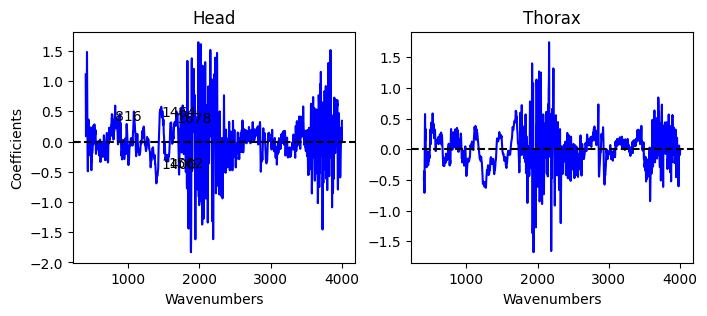

In [35]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(8,3),sharex=True)

sn.lineplot(x=wavenumbers,y=best_model_head['model'].coef_[0], color='b',ax=ax)
#sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)),color='k',alpha=0.5,ax=ax)
ax.axhline(y=0, color="k", ls="--")
#ax.set_xlim(1800,600)
ax.annotate('1464', xy=(1464,0.4214), xycoords='data',fontsize=10)
ax.annotate('1678', xy=(1678,0.3214), xycoords='data',fontsize=10)
ax.annotate('816', xy=(816,0.344), xycoords='data',fontsize=10)
ax.annotate('1400', xy=(1464,-0.45), xycoords='data',fontsize=10)
ax.annotate('1562', xy=(1562,-0.42), xycoords='data',fontsize=10)
ax.set_xlabel("Wavenumbers")
ax.set_ylabel("Coefficients")
ax.set_title("Head")


sn.lineplot(x=wavenumbers,y=best_mdoel_thorax['model'].coef_[0], color='b',ax=ax2)
#sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*6),color='k',alpha=0.5,ax=ax2)
ax2.axhline(y=0, color="k", ls="--")
ax2.set_xlabel("Wavenumbers")
ax2.set_title("Thorax")
ax2.annotate('782', xy=(782,3.59), xycoords='data',fontsize=10)
ax2.annotate('1750', xy=(1750,3.214), xycoords='data',fontsize=10)
ax2.annotate('1464', xy=(1464,3.44), xycoords='data',fontsize=10)
ax2.annotate('1692', xy=(1692, 2.785488), xycoords='data',fontsize=10)
ax2.annotate('772', xy=(772,-2.59), xycoords='data',fontsize=10)

ax2.annotate('686', xy=(686,	-2.576248), xycoords='data',fontsize=10)
ax2.annotate('1720', xy=(1720, -2.324863), xycoords='data',fontsize=10)

ax2.annotate('1040', xy=(1040,-2.260752), xycoords='data',fontsize=10)

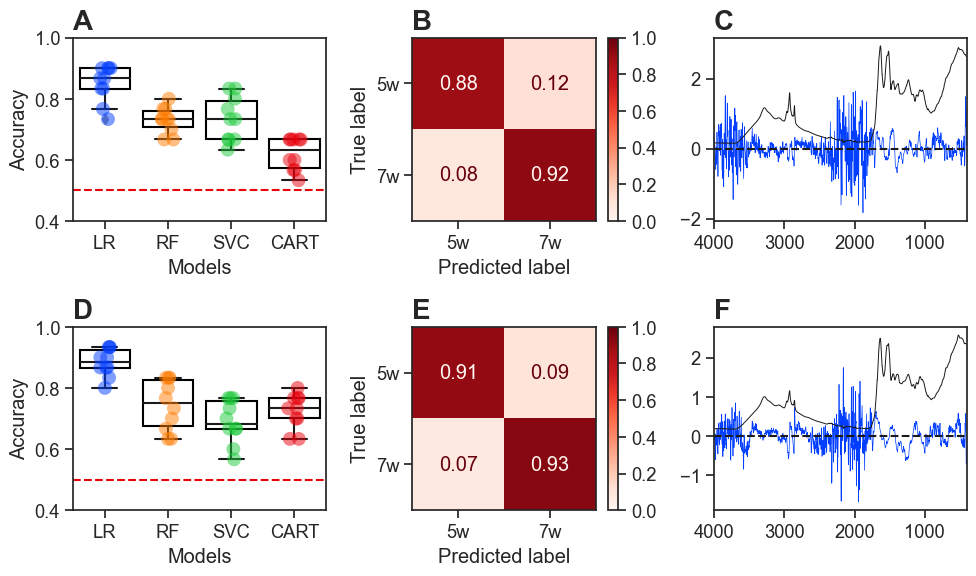

In [85]:
# Final plot age prediction males
sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10,6), tight_layout=True)

# boxplots
sn.boxplot(data=data_plot_head, x='param_clf',y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value',ax=ax, size=10,alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax.lines, color = 'k')
for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')
ax.axhline(0.5, ls="--", color='r')
ax.set_ylim(0.4,1)

sn.boxplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax4, color="white")
sn.stripplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax4, size=10, alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax4.lines,color='k')
for l, box in enumerate(ax4.patches):
    box.set_edgecolor("black")
ax4.axhline(0.5, ls='--', color='r')
ax4.set_ylim(0.4,1)



plots1 = [ax,ax4]

for i in plots1:
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")

# coefficients
sn.lineplot(x=wavenumbers,y=best_model_head['model'].coef_[0], color='b',ax=ax3, linewidth=0.5)
sn.lineplot(x=wavenumbers,y=best_mdoel_thorax['model'].coef_[0], color='b',ax=ax6, linewidth=0.5)
ax3.set_xlim(4000,402)
ax6.set_xlim(4000,402)

sn.lineplot(x=wavenumbers, y = np.mean(X_head_part1, axis=0)*10, color='k', ax=ax3, linewidth=0.7)
sn.lineplot(x=wavenumbers, y = np.mean(X_thorax_part1, axis=0)*9, color='k', ax=ax6, linewidth=0.7)

ax3.axhline(0, ls='--', color='k')
ax6.axhline(0, ls='--', color='k')

# confusion matrices
disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax5, im_kw={'vmin':0, 'vmax':1})

plots1 = [ax,ax2,ax3,ax4,ax5,ax6]
letters = ["A", "B", "C", "D", "E", "F"]

for p, t in zip(plots1, letters):
    p.set_title(t, loc="left", weight='bold', fontsize=20)

plt.savefig("../results/plots/age_prediction_males.png", dpi=300)

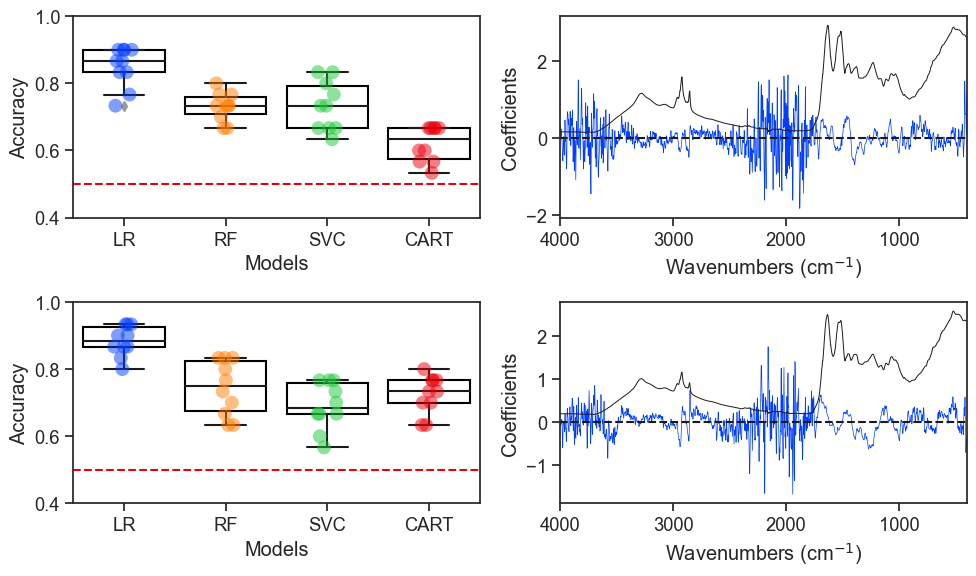

In [108]:
# Final plot age prediction males
sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10,6), tight_layout=True)

# boxplots
sn.boxplot(data=data_plot_head, x='param_clf',y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value',ax=ax, size=10,alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax.lines, color = 'k')
for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')
ax.axhline(0.5, ls="--", color='r')
ax.set_ylim(0.4,1)


sn.boxplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax3, color="white")
sn.stripplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax3, size=10, alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax3.lines,color='k')
for l, box in enumerate(ax3.patches):
    box.set_edgecolor("black")
ax3.axhline(0.5, ls='--', color='r')
ax3.set_ylim(0.4,1)



plots1 = [ax,ax3]

for i in plots1:
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")

plots1 = [ax2,ax4]

for i in plots1:
    i.set_xlabel("Wavenumbers (cm$^{-1}$)")
    i.set_ylabel("Coefficients")

# coefficients
sn.lineplot(x=wavenumbers,y=best_model_head['model'].coef_[0], color='b',ax=ax2, linewidth=0.5)
sn.lineplot(x=wavenumbers,y=best_mdoel_thorax['model'].coef_[0], color='b',ax=ax4, linewidth=0.5)
ax2.set_xlim(4000,402)
ax4.set_xlim(4000,402)

sn.lineplot(x=wavenumbers, y = np.mean(X_head_part1, axis=0)*10, color='k', ax=ax2, linewidth=0.7)
sn.lineplot(x=wavenumbers, y = np.mean(X_thorax_part1, axis=0)*9, color='k', ax=ax4, linewidth=0.7)

ax2.axhline(0, ls='--', color='k')
ax4.axhline(0, ls='--', color='k')


plots1 = [ax,ax2,ax3,ax4,ax5,ax6]
letters = ["A", "B", "C", "D", "E", "F"]

#for p, t in zip(plots1, letters):
#    p.set_title(t, loc="left", weight='bold', fontsize=20)

plt.savefig("../results/plots/age_prediction_males.png", dpi=900)

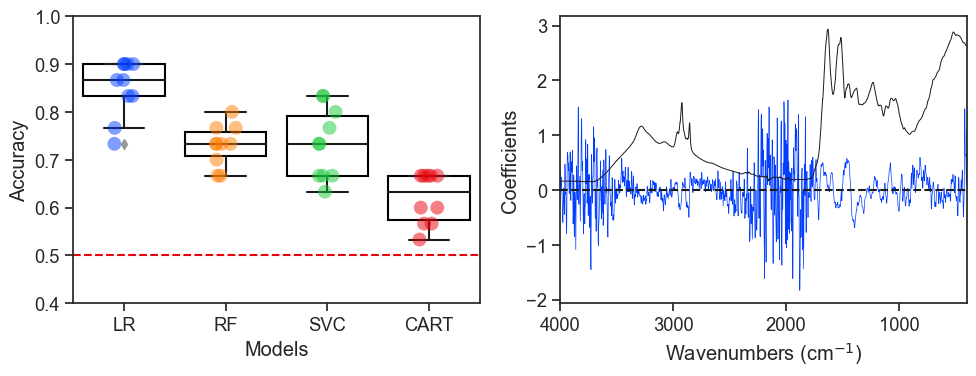

In [110]:
# Final plot age prediction males
sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

# boxplots
sn.boxplot(data=data_plot_head, x='param_clf',y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value',ax=ax, size=10,alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax.lines, color = 'k')
for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')
ax.axhline(0.5, ls="--", color='r')
ax.set_ylim(0.4,1)


sn.boxplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax3, color="white")
sn.stripplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax3, size=10, alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax3.lines,color='k')
for l, box in enumerate(ax3.patches):
    box.set_edgecolor("black")
ax3.axhline(0.5, ls='--', color='r')
ax3.set_ylim(0.4,1)



plots1 = [ax,ax3]

for i in plots1:
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")

plots1 = [ax2,ax4]

for i in plots1:
    i.set_xlabel("Wavenumbers (cm$^{-1}$)")
    i.set_ylabel("Coefficients")

# coefficients
sn.lineplot(x=wavenumbers,y=best_model_head['model'].coef_[0], color='b',ax=ax2, linewidth=0.5)
sn.lineplot(x=wavenumbers,y=best_mdoel_thorax['model'].coef_[0], color='b',ax=ax4, linewidth=0.5)
ax2.set_xlim(4000,402)
ax4.set_xlim(4000,402)

sn.lineplot(x=wavenumbers, y = np.mean(X_head_part1, axis=0)*10, color='k', ax=ax2, linewidth=0.7)
sn.lineplot(x=wavenumbers, y = np.mean(X_thorax_part1, axis=0)*9, color='k', ax=ax4, linewidth=0.7)

ax2.axhline(0, ls='--', color='k')
ax4.axhline(0, ls='--', color='k')


plots1 = [ax,ax2,ax3,ax4,ax5,ax6]
letters = ["A", "B", "C", "D", "E", "F"]

#for p, t in zip(plots1, letters):
 #   p.set_title(t, loc="left", weight='bold', fontsize=20)

plt.savefig("../results/plots/age_prediction_males_v2.pdf", dpi=900)